In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [151]:
# Load accuracy .csv and times.csv
time_path = '../../results/mini_train/times.csv'
acc_path = '../../results/mini_accuracy.csv'

def get_max_n(row):
    return max(row['n_dets'],row['n_trks'])

time_df = pd.read_csv(time_path)
time_df['n_max'] = time_df.apply(get_max_n, axis=1)
acc_df = pd.read_csv(acc_path)

# Get mask of dataset
split='mini_train'
split_df = acc_df[acc_df['split']==split]

# Plot 1: Linearity in O(n)

0.0001965073634374152
0.0018570565714285715
197674


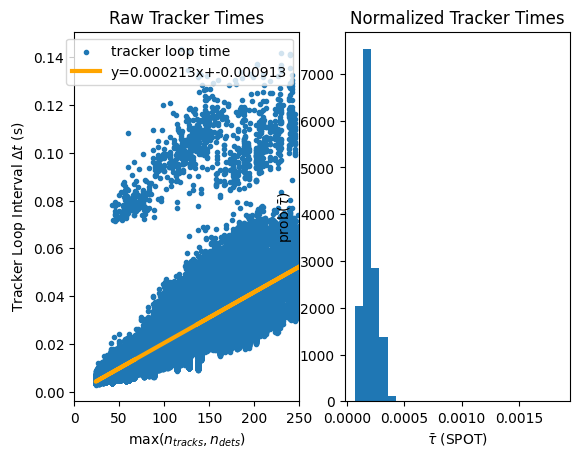

In [158]:
# Generate timing plot
z, residuals, rank, singular_values, rcond = np.polyfit(time_df['n_max'],time_df['time_ns']/1000000000,1,full=True)
p = np.poly1d(z)

n_bins=25
fig, axs = plt.subplots(1, 2, tight_layout=False)
axs[0].scatter(time_df['n_max'],time_df['time_ns']/1000000000,marker='.')
axs[0].set_xlim([0,250])
axs[0].set_title('Raw Tracker Times')
axs[0].set_xlabel('max($n_{tracks},n_{dets}$)')
axs[0].set_ylabel('Tracker Loop Interval $\Delta t$ (s)')
axs[0].plot(time_df['n_max'],p(time_df['n_max']),color="orange", linewidth=3, linestyle="-")
axs[0].legend(['tracker loop time',"y=%.6fx+%.6f"%(z[0],z[1])])
axs[1].hist(time_df['time_ns']/(time_df['n_max']*1000000000),density=True,stacked=True, bins=n_bins) #, bins=n_bins
axs[1].set_title('Normalized Tracker Times')
axs[1].set_ylabel('prob($\\bar{\\tau}$)')
axs[1].set_xlabel('$\\bar{\\tau}$ (SPOT)')

print(np.mean(time_df['time_ns']/(time_df['n_max']*1000000000)))
print(np.max(time_df['time_ns']/(time_df['n_max']*1000000000)))
print(len(time_df['time_ns']))

# Plot 2: Effects of yaw correction

In [190]:
# Get all indices of yc, and no_yc
yc_acc_df = split_df[['_yc_' in row for row in split_df['exp_config']]]
noyc_acc_df = split_df[['_noyc_' in row for row in split_df['exp_config']]]
yc_time_df = time_df[time_df['config'].str.contains("_yc")]
noyc_time_df = time_df[time_df['config'].str.contains("_noyc")]

assert(len(yc_acc_df)==len(noyc_acc_df))

In [191]:
# Compute change in accuracy
diff_array = np.zeros((len(yc_acc_df),8))
diff_idx = 0

for idx, yc_row in yc_acc_df.iterrows():
    yc_config = yc_row['exp_config']   
    noyc_config = yc_config.replace('yc','noyc')
    noyc_row = noyc_acc_df[noyc_acc_df['exp_config']==noyc_config]

    diff_array[diff_idx,0] = float(yc_row['amota']) - float(noyc_row['amota'])
    diff_array[diff_idx,1] = float(yc_row['bicycle_amota']) - float(noyc_row['bicycle_amota'])
    diff_array[diff_idx,2] = float(yc_row['bus_amota']) - float(noyc_row['bus_amota'])
    diff_array[diff_idx,3] = float(yc_row['car_amota']) - float(noyc_row['car_amota'])
    diff_array[diff_idx,4] = float(yc_row['moto_amota']) - float(noyc_row['moto_amota'])
    diff_array[diff_idx,5] = float(yc_row['ped_amota']) - float(noyc_row['ped_amota'])
    diff_array[diff_idx,6] = float(yc_row['trailer_amota']) - float(noyc_row['trailer_amota'])
    diff_array[diff_idx,7] = float(yc_row['truck_amota']) - float(noyc_row['truck_amota'])
    diff_idx +=1

diff_df = pd.DataFrame(diff_array, columns=['all','bike','bus','car','moto','ped','trailer','truck'])


/tmp/ipykernel_16299/3369529616.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  diff_array[diff_idx,0] = float(yc_row['amota']) - float(noyc_row['amota'])
/tmp/ipykernel_16299/3369529616.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  diff_array[diff_idx,1] = float(yc_row['bicycle_amota']) - float(noyc_row['bicycle_amota'])
/tmp/ipykernel_16299/3369529616.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  diff_array[diff_idx,2] = float(yc_row['bus_amota']) - float(noyc_row['bus_amota'])
/tmp/ipykernel_16299/3369529616.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  diff_array[diff

yc
0.00019632909154063927
0.0017622009555555555
98837

no_yc
0.00019668563533419115
0.0018570565714285715
98837

change in amota
all       -0.000641
bike      -0.000307
bus       -0.000350
car       -0.000052
moto       0.000278
ped        0.004895
trailer   -0.000150
truck     -0.008608
dtype: float64


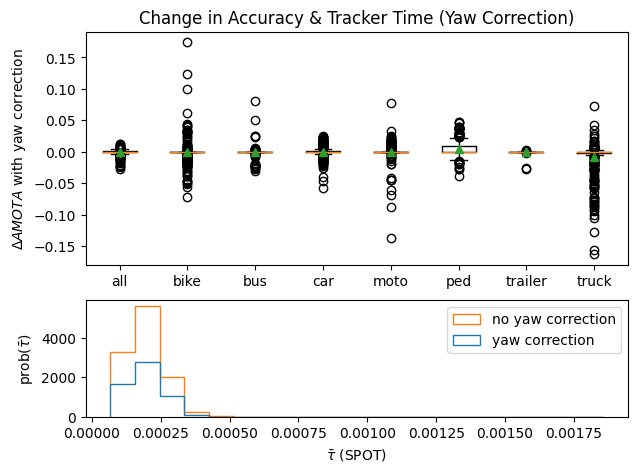

In [192]:
# Generate yaw_corr timing plot
n_bins=20
fig, axs = plt.subplots(2, 1, tight_layout=False, figsize=(7,5), gridspec_kw={'height_ratios': [2, 1]})

axs[0].set_title('Change in Accuracy & Tracker Time (Yaw Correction)')
axs[0].boxplot(diff_df, labels=diff_df.columns, showmeans=True)
axs[0].set_ylabel('$\Delta AMOTA$ with yaw correction')
axs[1].hist((yc_time_df['time_ns']/(yc_time_df['n_max']*1000000000),noyc_time_df['time_ns']/(noyc_time_df['n_max']*1000000000)),histtype='step',density=True,stacked=True, bins=n_bins, label=['yaw correction','no yaw correction']) #, bins=n_bins
# axs[1].set_title('Change in Tracker Loop Times')
axs[1].set_ylabel('prob($\\bar{\\tau}$)')
axs[1].set_xlabel('$\\bar{\\tau}$ (SPOT)')
axs[1].legend()

dir(fig)

print('yc')
print(np.mean(yc_time_df['time_ns']/(yc_time_df['n_max']*1000000000)))
print(np.max(yc_time_df['time_ns']/(yc_time_df['n_max']*1000000000)))
print(len(yc_time_df['time_ns']))
print()

print('no_yc')
print(np.mean(noyc_time_df['time_ns']/(noyc_time_df['n_max']*1000000000)))
print(np.max(noyc_time_df['time_ns']/(noyc_time_df['n_max']*1000000000)))
print(len(noyc_time_df['time_ns']))
print()

print('change in amota')
print(np.mean(diff_df,axis=0))


# Matching algorithm comparisons

In [193]:
# Get all indices of yc, and no_yc
hungar_acc_df = split_df[['hungar' in row for row in split_df['exp_config']]]
greedy_acc_df = split_df[['greedy' in row for row in split_df['exp_config']]]
hungar_time_df = time_df[time_df['config'].str.contains("hungar")]
greedy_time_df = time_df[time_df['config'].str.contains("greedy")]

assert(len(hungar_acc_df)==len(greedy_acc_df))

In [194]:
# Compute change in accuracy
diff_array = np.zeros((len(greedy_acc_df),8))
diff_idx = 0

for idx, greedy_row in greedy_acc_df.iterrows():
    greedy_config = greedy_row['exp_config']   
    hungar_config = greedy_config.replace('greedy','hungarian')
    hungar_row = hungar_acc_df[hungar_acc_df['exp_config']==hungar_config]

    diff_array[diff_idx,0] = float(greedy_row['amota']) - float(hungar_row['amota'])
    diff_array[diff_idx,1] = float(greedy_row['bicycle_amota']) - float(hungar_row['bicycle_amota'])
    diff_array[diff_idx,2] = float(greedy_row['bus_amota']) - float(hungar_row['bus_amota'])
    diff_array[diff_idx,3] = float(greedy_row['car_amota']) - float(hungar_row['car_amota'])
    diff_array[diff_idx,4] = float(greedy_row['moto_amota']) - float(hungar_row['moto_amota'])
    diff_array[diff_idx,5] = float(greedy_row['ped_amota']) - float(hungar_row['ped_amota'])
    diff_array[diff_idx,6] = float(greedy_row['trailer_amota']) - float(hungar_row['trailer_amota'])
    diff_array[diff_idx,7] = float(greedy_row['truck_amota']) - float(hungar_row['truck_amota'])
    diff_idx +=1

diff_df = pd.DataFrame(diff_array, columns=['all','bike','bus','car','moto','ped','trailer','truck'])


/tmp/ipykernel_16299/2036069811.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  diff_array[diff_idx,0] = float(greedy_row['amota']) - float(hungar_row['amota'])
/tmp/ipykernel_16299/2036069811.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  diff_array[diff_idx,1] = float(greedy_row['bicycle_amota']) - float(hungar_row['bicycle_amota'])
/tmp/ipykernel_16299/2036069811.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  diff_array[diff_idx,2] = float(greedy_row['bus_amota']) - float(hungar_row['bus_amota'])
/tmp/ipykernel_16299/2036069811.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

greedy
0.0002096342306674186
0.0018570565714285715
98837

hungarian
0.00018338049620741183
0.0018085122
98837

change in amota
all        0.053105
bike       0.012327
bus        0.034422
car        0.122444
moto       0.034977
ped        0.076634
trailer    0.000268
truck      0.090739
dtype: float64


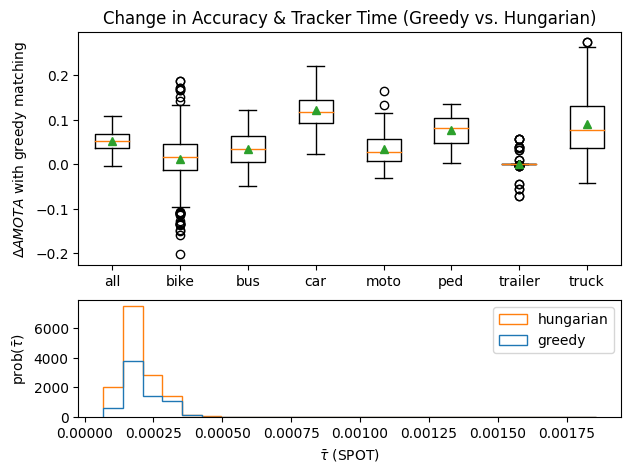

In [200]:
# Generate yaw_corr timing plot
n_bins=25
fig, axs = plt.subplots(2, 1, tight_layout=False, figsize=(7,5), gridspec_kw={'height_ratios': [2, 1]})

axs[0].set_title('Change in Accuracy & Tracker Time (Greedy vs. Hungarian)')
axs[0].boxplot(diff_df, labels=diff_df.columns, showmeans=True)
axs[0].set_ylabel('$\Delta AMOTA$ with greedy matching')
axs[1].hist((greedy_time_df['time_ns']/(greedy_time_df['n_max']*1000000000),hungar_time_df['time_ns']/(hungar_time_df['n_max']*1000000000)),histtype='step',density=True,stacked=True, bins=n_bins, label=['greedy','hungarian']) #, bins=n_bins
# axs[1].set_title('Change in Tracker Loop Times')
axs[1].set_ylabel('prob($\\bar{\\tau}$)')
axs[1].set_xlabel('$\\bar{\\tau}$ (SPOT)')
axs[1].legend()

dir(fig)

print('greedy')
print(np.mean(greedy_time_df['time_ns']/(greedy_time_df['n_max']*1000000000)))
print(np.max(greedy_time_df['time_ns']/(greedy_time_df['n_max']*1000000000)))
print(len(greedy_time_df['time_ns']))
print()

print('hungarian')
print(np.mean(hungar_time_df['time_ns']/(hungar_time_df['n_max']*1000000000)))
print(np.max(hungar_time_df['time_ns']/(hungar_time_df['n_max']*1000000000)))
print(len(hungar_time_df['time_ns']))
print()

print('change in amota')
print(np.mean(diff_df,axis=0))

# Process model comparison

In [203]:
# Get all indices of yc, and no_yc
cvcy_acc_df = split_df[['_cvcy_c' in row for row in split_df['exp_config']]]
ack_acc_df = split_df[['_ack_' in row for row in split_df['exp_config']]]
cvcy_time_df = time_df[time_df['config'].str.contains("_cvcy_c")]
ack_time_df = time_df[time_df['config'].str.contains("_ack_")]

assert(len(cvcy_acc_df)==len(ack_acc_df))

In [204]:
# Compute change in accuracy
diff_array = np.zeros((len(cvcy_acc_df),8))
diff_idx = 0

for idx, cvcy_row in cvcy_acc_df.iterrows():
    cvcy_config = cvcy_row['exp_config']   
    ack_config = cvcy_config.replace('_cvcy_c','_ack_c')
    ack_row = hungar_acc_df[hungar_acc_df['exp_config']==hungar_config]

    diff_array[diff_idx,0] = float(cvcy_row['amota']) - float(ack_row['amota'])
    diff_array[diff_idx,1] = float(cvcy_row['bicycle_amota']) - float(ack_row['bicycle_amota'])
    diff_array[diff_idx,2] = float(cvcy_row['bus_amota']) - float(ack_row['bus_amota'])
    diff_array[diff_idx,3] = float(cvcy_row['car_amota']) - float(ack_row['car_amota'])
    diff_array[diff_idx,4] = float(cvcy_row['moto_amota']) - float(ack_row['moto_amota'])
    diff_array[diff_idx,5] = float(cvcy_row['ped_amota']) - float(ack_row['ped_amota'])
    diff_array[diff_idx,6] = float(cvcy_row['trailer_amota']) - float(ack_row['trailer_amota'])
    diff_array[diff_idx,7] = float(cvcy_row['truck_amota']) - float(ack_row['truck_amota'])
    diff_idx +=1

diff_df = pd.DataFrame(diff_array, columns=['all','bike','bus','car','moto','ped','trailer','truck'])


/tmp/ipykernel_16299/3015177025.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  diff_array[diff_idx,0] = float(cvcy_row['amota']) - float(ack_row['amota'])
/tmp/ipykernel_16299/3015177025.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  diff_array[diff_idx,1] = float(cvcy_row['bicycle_amota']) - float(ack_row['bicycle_amota'])
/tmp/ipykernel_16299/3015177025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  diff_array[diff_idx,2] = float(cvcy_row['bus_amota']) - float(ack_row['bus_amota'])
/tmp/ipykernel_16299/3015177025.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  diff_array[d

cvcy
0.0001921062279739547
0.0016780430222222223
65892

ackermann
0.00019674757562397678
0.0018570565714285715
65891

change in amota
all        0.022725
bike       0.007402
bus       -0.014990
car        0.044824
moto      -0.069461
ped        0.042451
trailer   -0.001598
truck      0.149627
dtype: float64


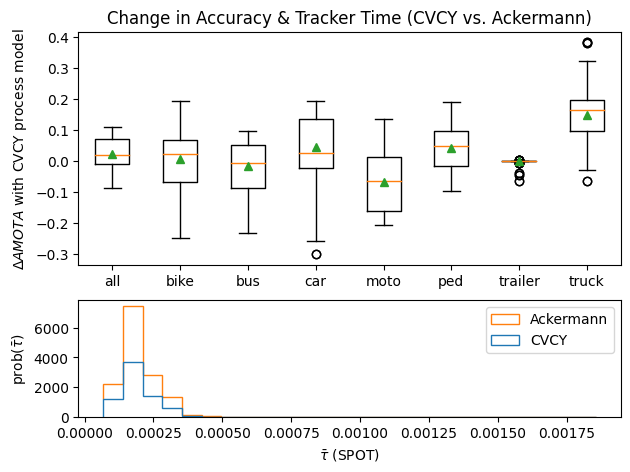

In [207]:
# Generate yaw_corr timing plot
n_bins=25
fig, axs = plt.subplots(2, 1, tight_layout=False, figsize=(7,5), gridspec_kw={'height_ratios': [2, 1]})

axs[0].set_title('Change in Accuracy & Tracker Time (CVCY vs. Ackermann)')
axs[0].boxplot(diff_df, labels=diff_df.columns, showmeans=True)
axs[0].set_ylabel('$\Delta AMOTA$ with CVCY process model')
axs[1].hist((cvcy_time_df['time_ns']/(cvcy_time_df['n_max']*1000000000),ack_time_df['time_ns']/(ack_time_df['n_max']*1000000000)),histtype='step',density=True,stacked=True, bins=n_bins, label=['CVCY','Ackermann']) #, bins=n_bins
# axs[1].set_title('Change in Tracker Loop Times')
axs[1].set_ylabel('prob($\\bar{\\tau}$)')
axs[1].set_xlabel('$\\bar{\\tau}$ (SPOT)')
axs[1].legend()

dir(fig)

print('cvcy')
print(np.mean(cvcy_time_df['time_ns']/(cvcy_time_df['n_max']*1000000000)))
print(np.max(cvcy_time_df['time_ns']/(cvcy_time_df['n_max']*1000000000)))
print(len(cvcy_time_df['time_ns']))
print()

print('ackermann')
print(np.mean(ack_time_df['time_ns']/(ack_time_df['n_max']*1000000000)))
print(np.max(ack_time_df['time_ns']/(ack_time_df['n_max']*1000000000)))
print(len(ack_time_df['time_ns']))
print()

print('change in amota')
print(np.mean(diff_df,axis=0))